# Degree-Grouped Permutations
In permuted networks, those node pairs having the same out- and in-degrees along the metapath are indistinguishable. This means that when computing permuted DWPC values, we can average not just over the five permutations for each, say compound-disease pair, but can average over all compound-disease pairs that have the same out- and in-degrees along the metapath.

In [64]:
import numpy as np
from scipy import sparse
import pandas as pd
import itertools
import hetio.readwrite

In [2]:
import sys
sys.path.insert(0, '../')
from hetmech.degree_weight import dwpc
from hetmech.matrix import metaedge_to_adjacency_matrix

In [3]:
repo_url = 'https://github.com/dhimmel/hetionet'
commit = '6d26d15e9055b33b4fd97a180fa288e4f2060b96'
names = ['hetionet-v1.0'] + [f'hetionet-v1.0-perm-{i + 1}' for i in range(5)]    
paths = ['hetnet/json/hetionet-v1.0.json.bz2'] + [
    f'hetnet/permuted/json/{name}.json.bz2' for name in names[1:]
]

In [4]:
metapaths = None
permuted = pd.DataFrame()
dwpc_df = pd.DataFrame()

for name, path in zip(names, paths):
    url = f'{repo_url}/raw/{commit}/{path}'
    graph = hetio.readwrite.read_graph(url)
    print(f'Loaded {name}')
    if not metapaths:
        metaedge = graph.metagraph.metapath_from_abbrev('CtD')
        metapaths = graph.metagraph.extract_metapaths(source=metaedge.source(), target=metaedge.target(), 
                                                      max_length=1)
    for metapath in metapaths:
        c, d, dwpc_matrix, t = dwpc(graph, metapath)
        print(f'metapath: {metapath}, time: {t}')
        
        out_degrees = np.sum(metaedge_to_adjacency_matrix(graph, metapath[0])[2], axis=1)
        in_degrees = np.sum(metaedge_to_adjacency_matrix(graph, metapath[-1])[2], axis=0)
        degree_combos = list(itertools.product(out_degrees, in_degrees))
        indices = list(itertools.product(range(len(out_degrees)), range(len(in_degrees))))
        index_df = pd.DataFrame(indices, columns=['row', 'col'])
        degree_combo_df = pd.DataFrame(degree_combos, columns=['source_degree', 'target_degree'])
        degree_index_df = index_df.join(degree_combo_df)
                
        # Add DWPC values
        degree_index_df['dwpc'] = degree_index_df.apply(lambda row: dwpc_matrix[row[0], row[1]], axis=1)
        degree_index_df['metapath'] = pd.Series([metapath] * len(degree_index_df))
        degree_index_df.drop(columns=['row', 'col'])
        if 'perm' in name:
            permuted = permuted.append(degree_index_df)
        else:
            dwpc_df = dwpc_df.append(degree_index_df)

Loaded hetionet-v1.0
metapath: CtD, time: 0.09569749499496538
metapath: CpD, time: 0.09502857099869289
Loaded hetionet-v1.0-perm-1
metapath: CtD, time: 0.09746511100092903
metapath: CpD, time: 0.09507147000113036
Loaded hetionet-v1.0-perm-2
metapath: CtD, time: 0.10262630401120987
metapath: CpD, time: 0.10103587999765296
Loaded hetionet-v1.0-perm-3
metapath: CtD, time: 0.10390301799634472
metapath: CpD, time: 0.10102417299640365
Loaded hetionet-v1.0-perm-4
metapath: CtD, time: 0.10441699200600851
metapath: CpD, time: 0.1031109710020246
Loaded hetionet-v1.0-perm-5
metapath: CtD, time: 0.10719663699273951
metapath: CpD, time: 0.10297018299752381


In [56]:
permuted.head(2)

,row,col,source_degree,target_degree,dwpc,metapath
0,0,0,2,0,0.0,(Compound - treats - Disease)
1,0,1,2,0,0.0,(Compound - treats - Disease)


## A single metapath:

In [7]:
permutation_df = permuted[permuted['metapath'] == metapaths[1]]

In [8]:
full_dwpc_df = dwpc_df[dwpc_df['metapath'] == metapaths[1]]

In [9]:
degree_grouped_permutations = pd.DataFrame(permutation_df
                                           .groupby(['source_degree', 'target_degree'])['dwpc']
                                           .apply(list)).reset_index()

In [10]:
degree_grouped_permutations.head(2)

,source_degree,target_degree,dwpc
0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
full_dwpc_df = full_dwpc_df.merge(degree_grouped_permutations, on=['source_degree', 'target_degree'])

In [12]:
full_dwpc_df.head(2)

,row,col,source_degree,target_degree,dwpc_x,metapath,dwpc_y
0,0,0,0,1,0.0,(Compound - palliates - Disease),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,3,0,1,0.0,(Compound - palliates - Disease),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
full_dwpc_df['p-dwpc'] = full_dwpc_df['dwpc_y'].apply(np.mean)
print('mean computed')
full_dwpc_df = full_dwpc_df.rename(columns={'dwpc_x': 'dwpc', 'dwpc_y': 'permutations'})
full_dwpc_df['r-dwpc'] = full_dwpc_df['dwpc'] - full_dwpc_df['p-dwpc']
full_dwpc_df['sd-dwpc'] = full_dwpc_df['permutations'].apply(np.std)
print('sd computed')
full_dwpc_df['z-dwpc'] = full_dwpc_df['r-dwpc'] / full_dwpc_df['sd-dwpc']

full_dwpc_df['z-dwpc'] = full_dwpc_df['z-dwpc'].fillna(0)

mean computed
sd computed


In [34]:
full_dwpc_df.head(2)

,row,col,source_degree,target_degree,dwpc,metapath,permutations,p-dwpc,r-dwpc,sd-dwpc,z-dwpc
0,0,0,0,1,0.0,(Compound - palliates - Disease),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0
1,0,3,0,1,0.0,(Compound - palliates - Disease),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0


In [92]:
nonzero_degrees = full_dwpc_df[(full_dwpc_df['source_degree'] != 0) & (full_dwpc_df['target_degree'] != 0)]

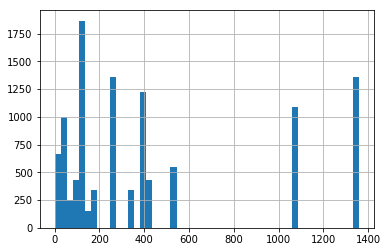

In [93]:
nonzero_degrees['permutations'].apply(lambda x: len(x) / 5).hist(bins=50)